In [7]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [2]:
# Define dataset path
DATASET_PATH = './data/leaf_coffe_dataset'
IMG_SIZE = 224
BATCH_SIZE = 32

# Get class names
class_names = os.listdir(DATASET_PATH)
NUM_CLASSES = len(class_names)

# List all image paths and labels
image_paths = []
labels = []

for i, class_name in enumerate(class_names):
    class_path = os.path.join(DATASET_PATH, class_name)
    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(i)  # Assign a numeric label

In [3]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Split temp (30%) into 20% test, 10% validation
test_paths, val_paths, test_labels, val_labels = train_test_split(
    temp_paths, temp_labels, test_size=1/3, stratify=temp_labels, random_state=42
)

# Print dataset sizes
print(f"Training set: {len(train_paths)} images")
print(f"Testing set: {len(test_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 40984 images
Testing set: 11710 images
Validation set: 5855 images


In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Training generator (70%)
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset=None  # No predefined subset, using custom split
)

# Test generator (20%)
test_generator = test_val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset=None,
    shuffle=False
)

# Validation generator (10%)
val_generator = test_val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset=None,
    shuffle=False
)

Found 58549 images belonging to 5 classes.
Found 58549 images belonging to 5 classes.
Found 58549 images belonging to 5 classes.


In [5]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base layers

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation="softmax")(x)

# Create Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3
)



Epoch 1/3


1830/1830 [==============================] - 1989s 1s/step - loss: 0.0188 - accuracy: 0.9946 - val_loss: 3.3159e-05 - val_accuracy: 1.0000
Epoch 2/3
1830/1830 [==============================] - 1416s 774ms/step - loss: 1.3953e-04 - accuracy: 1.0000 - val_loss: 6.7482e-06 - val_accuracy: 1.0000
Epoch 3/3
1830/1830 [==============================] - 1146s 626ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 9.5656e-05 - val_accuracy: 1.0000


In [8]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training and validation loss and accuracy curves over epochs.
    
    Args:
        train_losses (list or array): Training loss values per epoch.
        val_losses (list or array): Validation loss values per epoch.
        train_accs (list or array): Training accuracy values per epoch.
        val_accs (list or array): Validation accuracy values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", marker="o", color="blue")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy", marker="o", color="blue")
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker="o", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def check_fit_status(train_losses, val_losses, train_accs, val_accs, 
                     acc_diff_threshold=0.1, low_acc_threshold=0.70, loss_ratio_threshold=1.5):
    """
    Evaluates whether the model is overfitting, underfitting, or has a good fit.
    
    Args:
        train_losses (list or array): Training loss values per epoch.
        val_losses (list or array): Validation loss values per epoch.
        train_accs (list or array): Training accuracy values per epoch.
        val_accs (list or array): Validation accuracy values per epoch.
        acc_diff_threshold (float): Minimum difference between training and validation
                                    accuracy to consider overfitting (default is 0.1 i.e., 10%).
        low_acc_threshold (float): Accuracy below which the model is considered to be underfitting (default is 0.70 i.e., 70%).
        loss_ratio_threshold (float): Ratio of validation loss to training loss above which to consider overfitting (default is 1.5).
    
    Returns:
        str: One of "Overfitting", "Underfitting", or "Good Fit".
    """
    # Get final epoch values
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]

    # Check for overfitting: training accuracy is much higher than validation accuracy
    # and validation loss is significantly higher than training loss.
    if (final_train_acc - final_val_acc) > acc_diff_threshold and (final_val_loss / final_train_loss) > loss_ratio_threshold:
        status = "Overfitting"
    # Check for underfitting: both accuracies are low.
    elif final_train_acc < low_acc_threshold and final_val_acc < low_acc_threshold:
        status = "Underfitting"
    else:
        status = "Good Fit"
    
    print("Final Training Accuracy: {:.2f}%".format(final_train_acc * 100))
    print("Final Validation Accuracy: {:.2f}%".format(final_val_acc * 100))
    print("Final Training Loss: {:.4f}".format(final_train_loss))
    print("Final Validation Loss: {:.4f}".format(final_val_loss))
    print("Model Fit Status: {}".format(status))
    
    return status

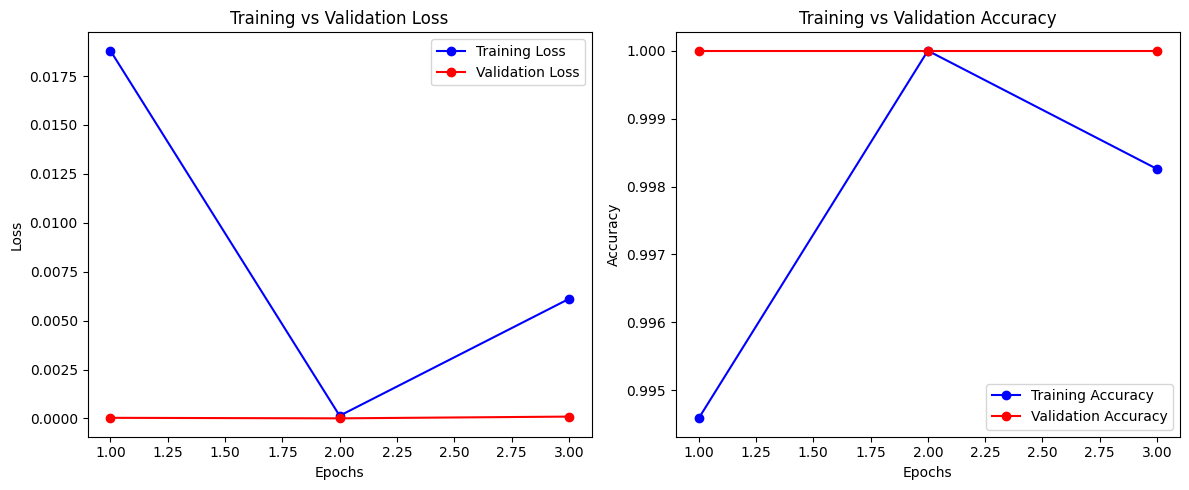

Final Training Accuracy: 99.83%
Final Validation Accuracy: 100.00%
Final Training Loss: 0.0061
Final Validation Loss: 0.0001
Model Fit Status: Good Fit


In [9]:
val_accs = history.history['val_accuracy']
train_accs = history.history['accuracy']
val_losses = history.history['val_loss']
train_losses = history.history['loss']

# Plot the training history
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Check the model fit status
fit_status = check_fit_status(train_losses, val_losses, train_accs, val_accs)